# Load the stored data

In this section, we will load the stored pickled data into memory.

First, set the names of the pickled files to load:

In [1]:
cell_names_file_name = "../data/cell_names"
gene_names_file_name = "../data/gene_names"
labels_file_name = "../data/labels"
gene_expr_bin_bitpacked_file_name = "../data/gene_expr_bin_bitpacked"

Then, actually load the data in those files

In [2]:
from ctc_utils.functions import load_pickled_cells_data

(cell_names, gene_names, labels, gene_expr_bin) = load_pickled_cells_data(
    cell_names_file_name,
    gene_names_file_name,
    labels_file_name,
    gene_expr_bin_bitpacked_file_name + ".npy",
)


# Partition into seperate datasets

Define gene expressions per dataset

In [3]:

ge_10xv2 = gene_expr_bin[0:6443]
ge_SM2 = gene_expr_bin[6444:6696]
ge_10xv3 = gene_expr_bin[6697:9918]
ge_CL = gene_expr_bin[9919:10171]
ge_DR = gene_expr_bin[10172:13393]
ge_iD = gene_expr_bin[13394:16615]
ge_SW = gene_expr_bin[16616:19791]
ge_10xv2_2 = gene_expr_bin[19792:23153]

Define labels per dataset

In [4]:
lb_10xv2 = labels[0:6443]
lb_SM2 = labels[6444:6696]
lb_10xv3 = labels[6697:9918]
lb_CL = labels[9919:10171]
lb_DR = labels[10172:13393]
lb_iD = labels[13394:16615]
lb_SW = labels[16616:19791]
lb_10xv2_2 = labels[19792:23153]

# Choose datasets

In [5]:
# Define dataset to be used
import numpy as np

x = gene_expr_bin
y = labels

# Only useful if you will use different datasets for train and test.
x_dt_test = ge_SW
y_dt_test = lb_SW

# Feature selection

In [6]:
from sklearn.feature_selection import VarianceThreshold

sel = VarianceThreshold(threshold=0.14)
x = sel.fit_transform(x)
x_dt_test = sel.transform(x_dt_test)


# Data Overview

Plot cell type number of occurances in each dataset.

Dataset: 10xv2 6443


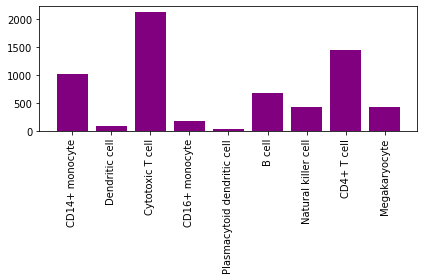



Dataset: SM2 252


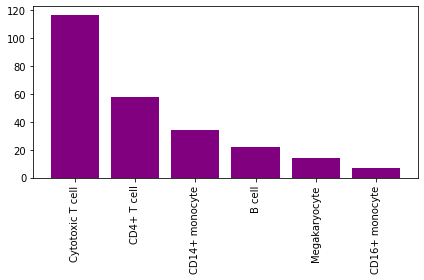



Dataset: 10xv3 3221


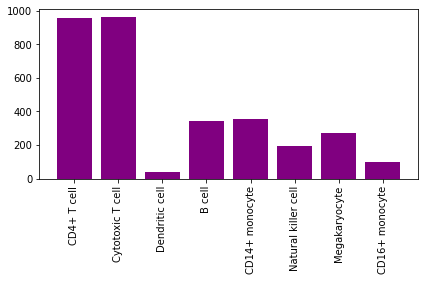



Dataset: CL 252


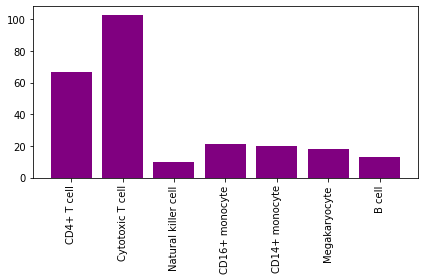



Dataset: DR 3221


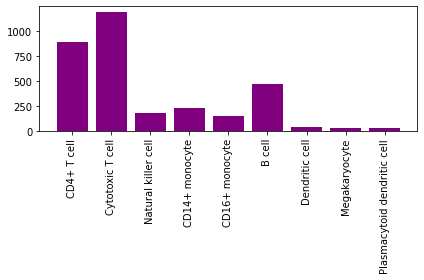



Dataset: iD 3221


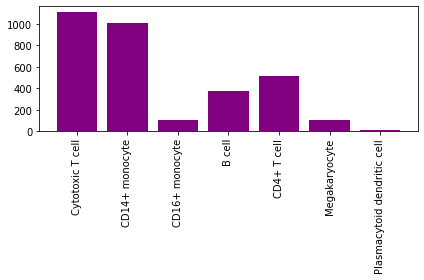



Dataset: SW 3175


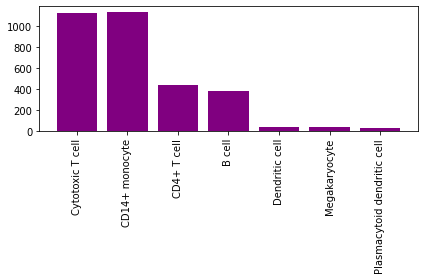



Dataset: 10xv2_2 3361


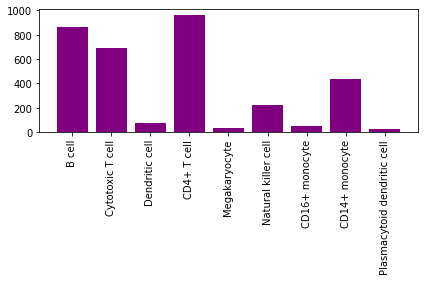



Training Dataset


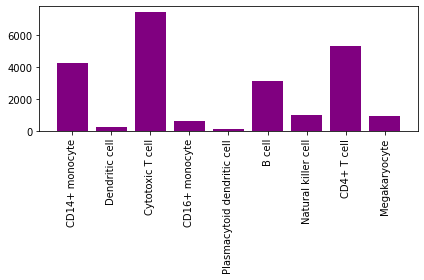

Test Dataset


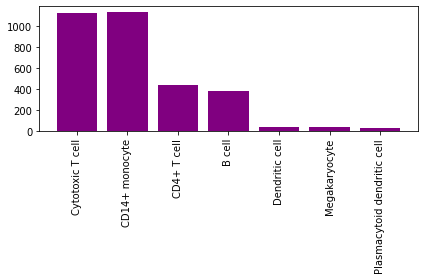

In [7]:
from ctc_utils.functions import plot_cell_type_counts

Dataset_Names = ["10xv2","SM2","10xv3","CL","DR","iD","SW","10xv2_2"]
Dataset_Labels = [lb_10xv2, lb_SM2, lb_10xv3, lb_CL,lb_DR, lb_iD,lb_SW,lb_10xv2_2]

for indx in range(len(Dataset_Names)):
    print("Dataset: " + Dataset_Names[indx], len(Dataset_Labels[indx]) )
    plot_cell_type_counts(Dataset_Labels[indx])
    print("\n")

print("Training Dataset")
plot_cell_type_counts(y)

print("Test Dataset")
plot_cell_type_counts(y_dt_test)

# Divide the test and training data

From the loaded data, divide it into training and test data

In [8]:
import pandas as pd

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)

# (Optional) Test with different datasets

Comment out, if you want to evaluate performance on the selected dataset for training (partitioning).

In [21]:
x_train = ge_10xv2
y_train = lb_10xv2
x_test = ge_CL
y_test = lb_CL

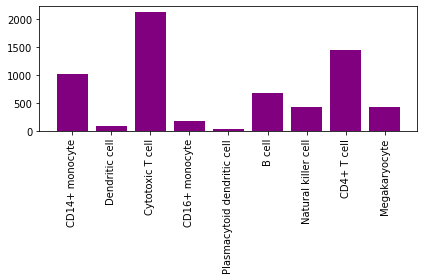

In [22]:
from ctc_utils.functions import  plot_cell_type_counts
plot_cell_type_counts(y_train)

# Feature selection

In [23]:
from sklearn.feature_selection import VarianceThreshold

sel = VarianceThreshold(threshold=0.16)
X = sel.fit_transform(x)

# Create Hierarchy

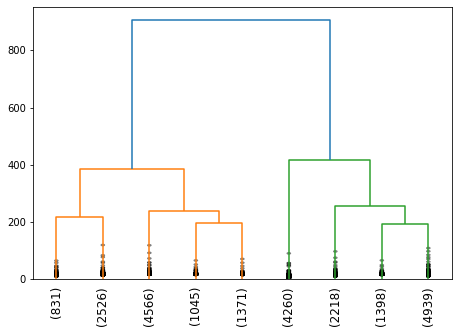

In [24]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

linkage_matrix = linkage(X, 'ward')

figure = plt.figure(figsize=(7.5, 5))

R = dendrogram(
    linkage_matrix,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=9,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
)

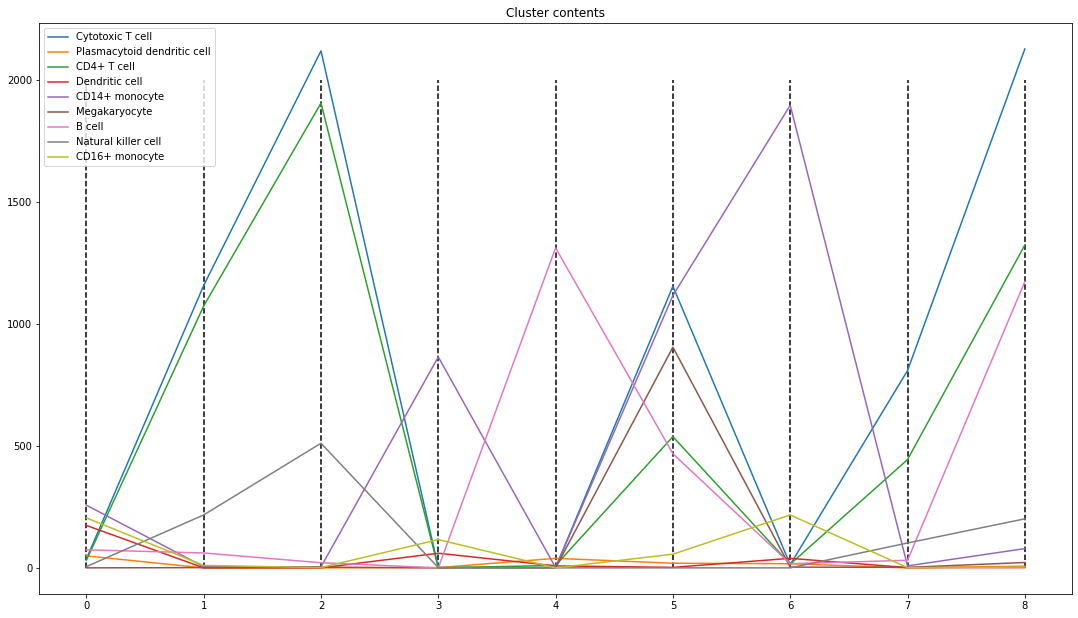

In [36]:
from scipy.cluster.hierarchy import ward, fcluster
from scipy.spatial.distance import pdist

res = fcluster(linkage_matrix, t=9, criterion='maxclust')

celltypes_occurences_per_cluster = []

for i in range(9):
    celltypes_occurences_per_cluster.append(dict((el,0) for el in set(y)))

for index, value in enumerate(res):
    celltypes_occurences_per_cluster[value-1][y[index]] += 1

fig, ax = plt.subplots()

lbl = list(range(9))

counts_per_cluster = []

for cell_type in set(y):
    occurences_per_cluster_current_cell = []

    for i in range(9):
        occurences_per_cluster_current_cell.append(celltypes_occurences_per_cluster[i][cell_type])

    counts_per_cluster.append(occurences_per_cluster_current_cell)

    ax.plot(lbl, occurences_per_cluster_current_cell, label=cell_type)

counts_per_cluster = np.array(counts_per_cluster)

ax.vlines(lbl, 0, 2000, color="black", linestyles = "dashed")
fig.set_size_inches(18.5, 10.5)
ax.legend()
ax.set_title("Cluster contents")
fig1 = plt.gcf()
fig1.savefig("../results/report_pdf_results/hierarchy.pdf", format='pdf', bbox_inches='tight')
plt.show()

# Hierarchical classifier

In [26]:
from sklearn_hierarchical_classification.classifier import HierarchicalClassifier
from sklearn_hierarchical_classification.constants import ROOT
from sklearn import svm

Define taxonomy

In [27]:
class_hierarchy = {

ROOT: ["cl","cmp"],
"cl": ["Natural killer cell","small lymphocytes"],
"cmp": ["Megakaryocyte", "Monocytes", "apc"],
"small lymphocytes": ["B cell", "T cell"],
"T cell": ["CD4+ T cell", "Cytotoxic T cell"],
"Monocytes": ["CD14+ monocyte", "CD16+ monocyte"],
"apc":["Dendritic cell", "pdc"], 
"pdc": ["Plasmacytoid dendritic cell"]
}

# class_hierarchy = {
# ROOT: ["clp","cmp"],
# "clp": ["small lymphocytes"],
# "cmp": ["Megakaryocyte", "Monocytes", "apc"],
# "small lymphocytes": ["B cell", "T cell", "Natural killer cell"],
# "T cell": ["CD4+ T cell", "Cytotoxic T cell"],
# "Monocytes": ["CD14+ monocyte", "CD16+ monocyte"],
# "apc":["Dendritic cell", "pdc"], 
# "pdc": ["Plasmacytoid dendritic cell"]
# }


In [28]:
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import TruncatedSVD

base_estimator = make_pipeline(
        TruncatedSVD(n_components=65),
        svm.SVC(probability= True)
    )


In [29]:
clf = HierarchicalClassifier(
        base_estimator=base_estimator,
        class_hierarchy=class_hierarchy    
    )

In [30]:
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
                      precision    recall  f1-score   support

             B cell       1.00      1.00      1.00        13
     CD14+ monocyte       0.94      0.75      0.83        20
     CD16+ monocyte       0.80      0.76      0.78        21
        CD4+ T cell       0.72      0.99      0.83        67
   Cytotoxic T cell       0.87      0.76      0.81       103
     Dendritic cell       0.00      0.00      0.00         0
      Megakaryocyte       1.00      0.50      0.67        18
Natural killer cell       0.25      0.20      0.22        10

           accuracy                           0.79       252
          macro avg       0.70      0.62      0.64       252
       weighted avg       0.82      0.79      0.79       252



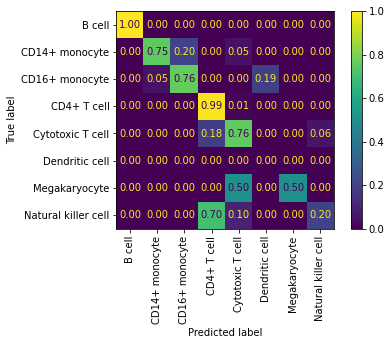

In [31]:
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

print("Classification Report:\n", classification_report(y_test, y_pred))

plot_confusion_matrix(clf, x_test, y_test, xticks_rotation = "vertical", normalize = "true", values_format = ".2f")  
plt.show()